# Derive models of drone

Do all imports.

In [18]:
import sympy as sym
import numpy as np

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Dynamic model

Define physical parameters.

In [19]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [20]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

In [21]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

## Sensor model

Define the sensor model.

In [22]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta, \phi)$$

Here is the function $g$:

In [23]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

## Find A and B

In [24]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

m = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z)
n = (tau_x,tau_y,tau_z,f_z)
mn = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z)

An = sym.lambdify(mn, f.jacobian(m))
Bn = sym.lambdify(mn, f.jacobian(n))

A = An(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
B = Bn(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
print("Matrix A:")
print(A.tolist())
# display(sym.Matrix(A))
print("Matrix B:")
print(B.tolist())
# display(sym.Matrix(B))

Matrix A:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Matrix B:
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0,

In [25]:
def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

Implement the best parameters from testing.

In [26]:
best = [4.2948504887081, 0.1010707509254879, 1.5128450787555376, 2.9281289875093144, 4.021479626235946, 0.21418643532574677, 99.4228232263525, 6.472917614299309, 11.529675605900664, 0.7576178164502525, 1.6655347053552063]

(
    k_att_i, k_rep_i, k_des_i, emax_i,
    Qom, Qm, tau_i,
    pz_i, rot_i, rot_v, tm
) = best

In [27]:
Q = np.diag((1,1,pz_i,rot_i,rot_i,rot_i,rot_v,rot_v,tm,1,1,1)) * Qm
R = np.diag((tau_i,tau_i,tau_i,1)) * 1

W = B
for i in range(1, A.shape[0]):
    W = np.block([W, la.matrix_power(A, i) @ B])

if W.shape[0] == la.matrix_rank(W):
    print("System is controllable.")
    K = lqr(A,B,Q,R)
    print("Matrix K:")
    print(K.tolist())
    #display(sym.Matrix(K))
else:
    print("System is not controllable.")

System is controllable.
Matrix K:
[[2.537730796267532e-16, -0.046414420858442065, -7.747963026254882e-17, -1.850345116411051e-16, 1.2640463601507004e-17, 0.32196315639344675, 1.1492433860756873e-16, -0.06840151758427492, 1.7537504746429855e-16, 0.060293689413025736, -9.308296007281308e-18, 4.614674302294085e-18], [0.04641442085844195, 1.1855670661605458e-16, 1.1733262916870047e-16, 6.343531895760748e-17, 0.32196315639344625, -3.8596560863425087e-16, 0.06840151758427482, 1.591867275392391e-16, -7.097175948089408e-18, -9.308296007281308e-18, 0.060293689413025646, -6.809602242441407e-18], [-1.5276452906527113e-16, -3.102542823587346e-17, 1.3952188038084134e-16, 0.15760191129514034, -1.8072180866926369e-16, 6.409724566614473e-17, -1.0301696862299767e-16, -8.514783588075797e-17, 4.759107608379023e-17, 2.653437723819099e-18, -3.915521289403809e-18, 0.05843897461442726], [5.525099189797799e-16, -1.0893169996451389e-15, 1.1774596171266363, 3.8991080598664713e-17, 9.195015565636656e-17, 1.29106

In [28]:
o_e = g.subs({p_x: 0, p_y: 0, p_z: 0, psi: 0, theta: 0, phi: 0})
o_e = np.array(o_e.T.evalf())
o_e = np.array(o_e[0])
print(o_e)

[0 0.175000000000000 0 0 -0.175000000000000 0]


In [29]:
m = (p_x,p_y,p_z,psi,theta,phi)
n = ()
mn = (p_x,p_y,p_z,psi,theta,phi)

# No D because there are no inputs in the sensor model
Cn = sym.lambdify(mn, g.jacobian(m))
#Dn = sym.lambdify(mn, f.jacobian(n))

C = Cn(0,0,1,0,0,0)
C = np.hstack((C, np.zeros((C.shape[0], 6))))
#D = Dn(0,0,0,0,0,0)
print("Matrix C:")
print(C.tolist())
#display(sym.Matrix(C))
# print("Matrix D:")
# print(D.tolist())

Matrix C:
[[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [30]:
# Define weight matrices for LQR
Q0 = np.eye(C.shape[0]) * Qom
R0 = np.eye(A.shape[0]) * 1

O = C
for i in range(1, A.shape[0]):
    O = np.vstack([O, C @ la.matrix_power(A, i)])

if A.shape[0] == la.matrix_rank(O):
    print("System is observable.")
    L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T
    print("Matrix L:")
    print(L.tolist())
    #display(sym.Matrix(L))
else:
    print("System is not observable, the rank is", la.matrix_rank(O))

System is observable.
Matrix L:
[[3.888360118514796, -1.5474519950092658e-16, 2.218060373277292e-16, 3.888360118514796, -1.5474519950092658e-16, -2.2180603732772964e-16], [-2.2417224979067723e-16, 3.754838437569831, -0.38340217865083165, -8.531814921117592e-17, 3.754838437569831, 0.3834021786508312], [4.932667348476817e-18, -2.2397954182093406e-16, 1.8516871736229126, -4.9326673484772594e-18, -2.2397954182093406e-16, 1.8516871736229126], [-3.1801932044967582, 3.9672600165571813e-16, 2.1703006364345347e-16, 3.180193204496757, 3.9672600165571813e-16, -2.734034047689053e-16], [2.408393122016162, 1.4125724111507304e-16, 1.2513389835878165e-16, 2.408393122016162, 1.4125724111507304e-16, -1.251338983587826e-16], [1.0222463362379889e-15, -2.1908695922904657, 0.8622042561720802, 1.5126798046503477e-15, -2.1908695922904657, -0.8622042561720804], [13.108604598138479, 5.936926756094774e-16, 7.340730524330213e-16, 13.108604598138479, 5.936926756094774e-16, -7.340730524330241e-16], [-4.090411795398

In [31]:
print(la.eigvals(A - B@K).real < 0)
print(la.eigvals(A - L@C).real < 0)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]


# Setup and Run the Simulation

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
seed = 3608613279
print(seed)

simulator = ae353_drone.Simulator(seed=seed)

simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'top',          # type of view (start, top, right, left, or back)
)
simulator.clear_drones()

3608613279
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [33]:
class Controller:
    def __init__(self, dt = 0.04):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.o_e = o_e
        self.dt = dt
        self.xhat = np.zeros(12)
        self.t = 0

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        self.t = 0
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        # Get estimated position
        phat = xhat[0:3]

        # Choose goal
        pgoal = pos_ring
        
        ##############################
        
        # Define parameters
        k_att = 2.0
        k_rep = 0.3
        k_des = 2.5
        r_drone = 0.25  # <-- radius of a sphere that would completely contain each drone
        r_ring = 1.0    # <-- radius of each small ring
        
        # Get attractive part
        grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
        
        # Get repulsive part
        # - Initialize the gradient
        grad_h_rep = np.zeros(3)
        # - Add repulsive part for each other drone
        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            d = np.linalg.norm(phat - pobst) - r_drone
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # - Add repulsive part for next ring
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # - Add repulsive part for ground
        q = np.array([0., 0., 0.])
        n = np.array([0., 0., 1.])
        pobst = phat - np.dot(n, phat - q) * n
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # n.dot(p - q)
        grad_h_rep += np.zeros(3)           # <-- REPLACE WITH YOUR CODE
        #print(grad_h_rep)
        # Get desired position
        pdes = phat - k_des * (grad_h_att + grad_h_rep)
        
        ##############################
        
        # Make sure desired position is not too far away
        emax = 1.6
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        
        if la.norm(pgoal - phat,ord=2) < .7:
            #print('go thro')
            pdes += dir_ring * .3

        #print(la.norm(pdes - phat,ord=2))
        # Get desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
        u = -self.K @ (self.xhat - xdes)
        
        y = pos_markers - np.array([0,.175,0,0,-.175,0])
        # print(y)

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )

        tau_x, tau_y, tau_z, f_z = u + np.array([0,0,0,0.5*9.81])

        return tau_x, tau_y, tau_z, f_z
    




In [34]:
simulator.add_drone(Controller, 'template', 'template.png')
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 1,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 1,
            'yaw_meas': 0.,
        },
    },
)
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)
simulator.run(
    max_time=1.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 26 time steps in 1.0414 seconds (24.9672 time steps per second)


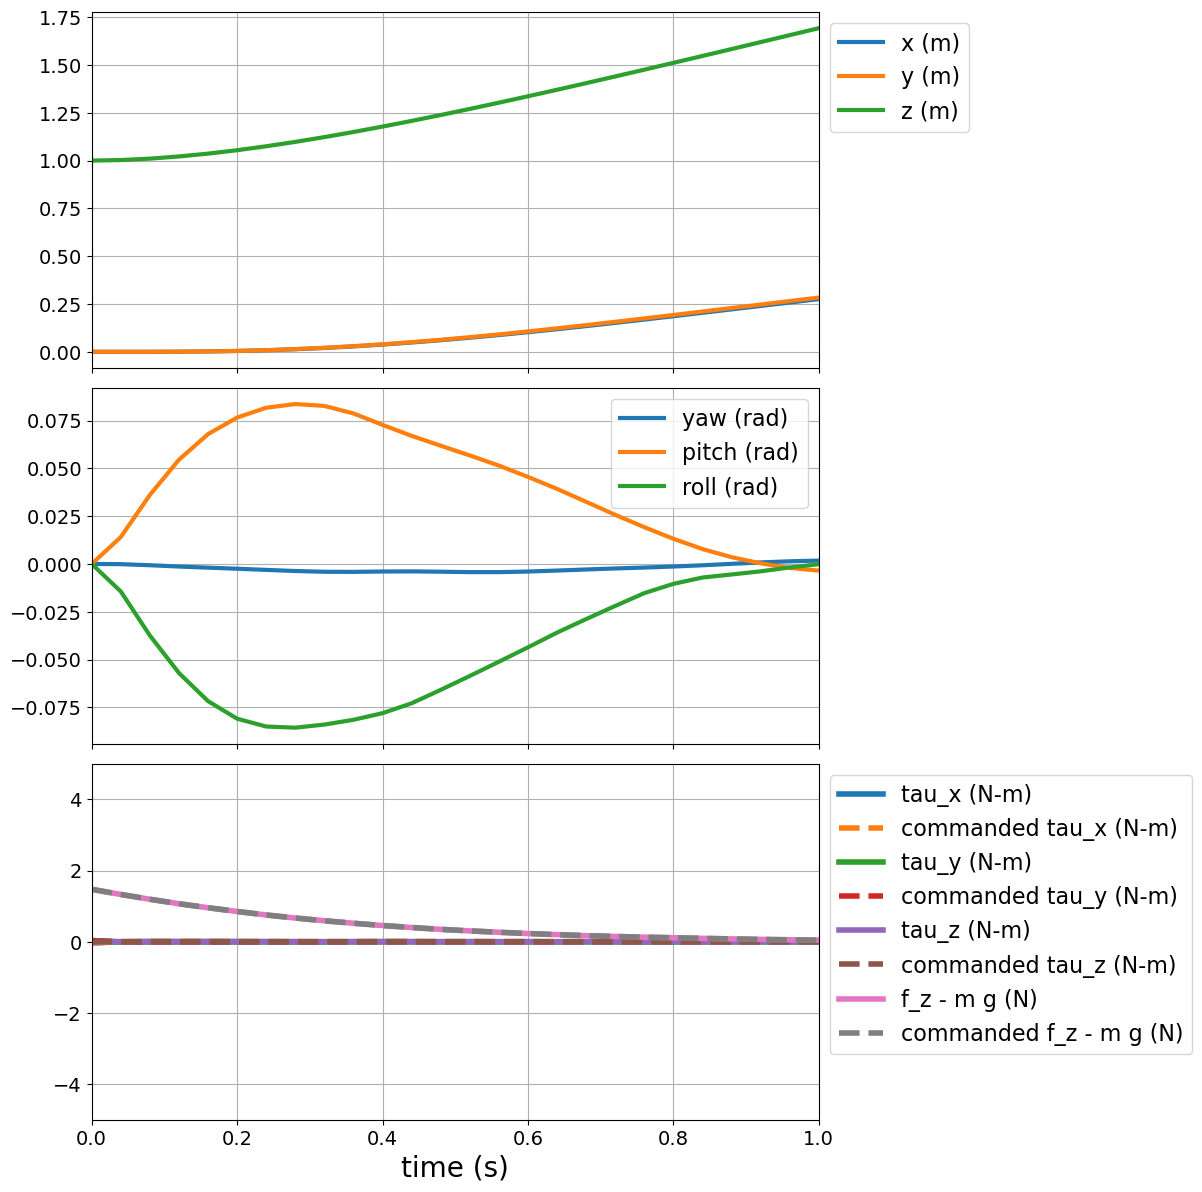

In [35]:
data = simulator.get_data('template')
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Measurements
# ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
# ax_meas.grid()
# ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
# ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z']) - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z_cmd']) - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4)
ax_act.set_ylim(-5, 5)  # Set both y-limits
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)



# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

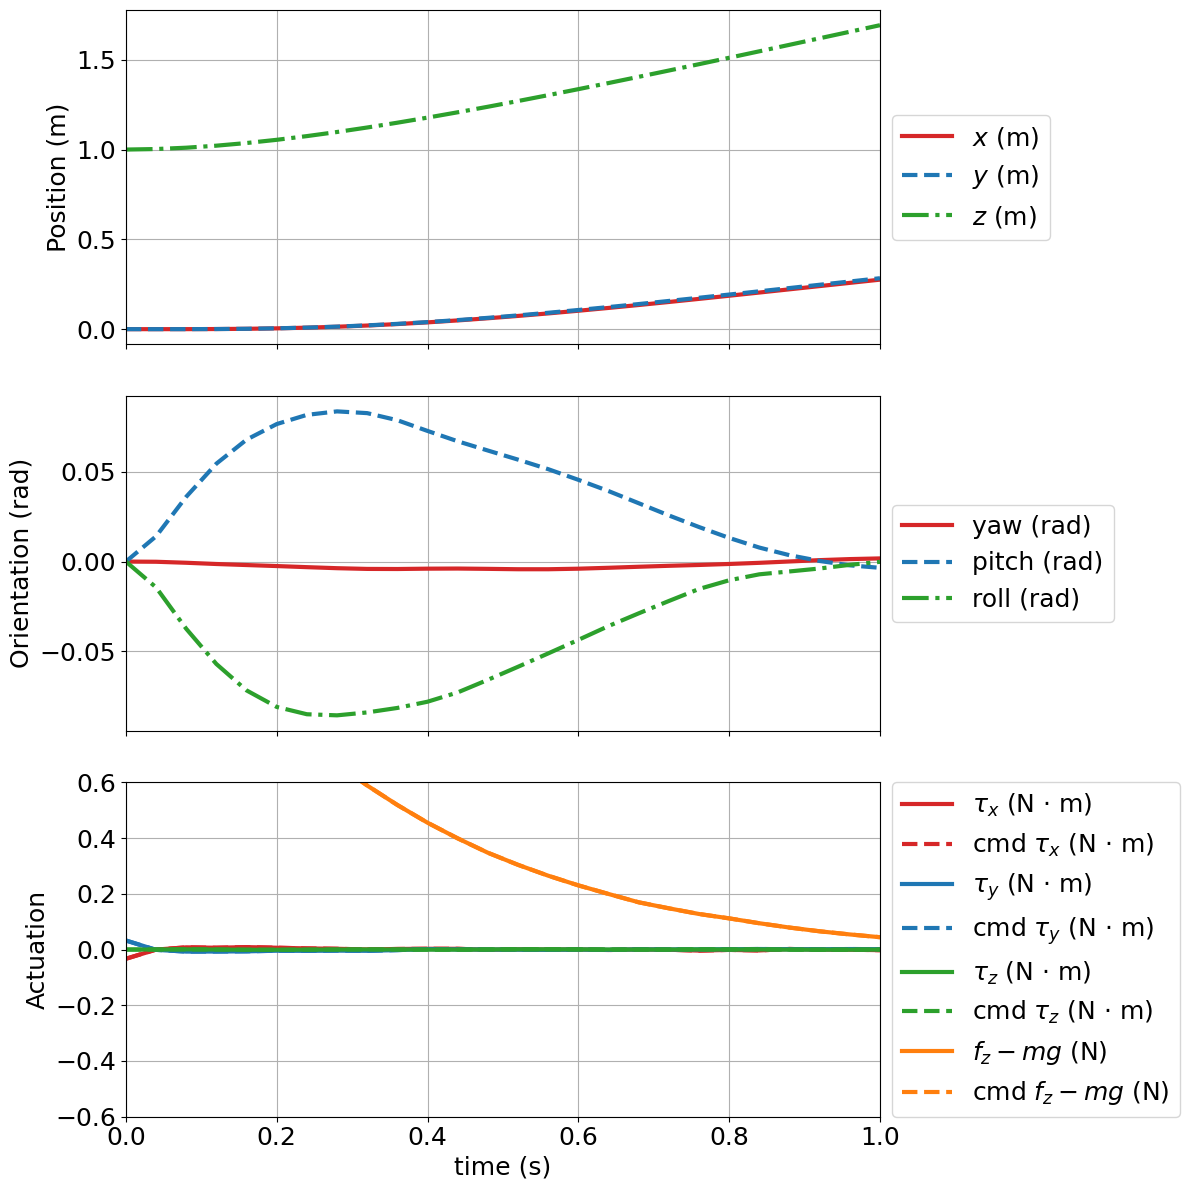

In [36]:
# Define a variable to control font size locally
font_size = 18

# Define consistent colors
color_x = 'tab:red'
color_y = 'tab:blue'
color_z = 'tab:green'
color_cmd = 'tab:orange'

# Define consistent linestyles
linestyles = ['-', '--', '-.', ':']

# Load data
data = simulator.get_data('template')

# Create figure with three subplots
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# ---- 1. Position ----
ax_pos.plot(data['t'], data['p_x'], label=r'$x$ (m)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_pos.plot(data['t'], data['p_y'], label=r'$y$ (m)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_pos.plot(data['t'], data['p_z'], label=r'$z$ (m)', linewidth=3, color=color_z, linestyle=linestyles[2])
ax_pos.set_ylabel("Position (m)", fontsize=font_size)
ax_pos.tick_params(labelsize=font_size)
ax_pos.grid()
ax_pos.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# ---- 2. Orientation ----
ax_ori.plot(data['t'], data['yaw'], label=r'yaw (rad)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_ori.plot(data['t'], data['pitch'], label=r'pitch (rad)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_ori.plot(data['t'], data['roll'], label=r'roll (rad)', linewidth=3, color=color_z, linestyle=linestyles[2])
ax_ori.set_ylabel("Orientation (rad)", fontsize=font_size)
ax_ori.tick_params(labelsize=font_size)
ax_ori.grid()
ax_ori.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# ---- 3. Actuator Commands ----
ax_act.plot(data['t'], data['tau_x'], label=r'$\tau_x$ (N $\cdot$ m)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_x_cmd'], label=r'cmd $\tau_x$ (N $\cdot$ m)', linewidth=3, color=color_x, linestyle=linestyles[1])
ax_act.plot(data['t'], data['tau_y'], label=r'$\tau_y$ (N $\cdot$ m)', linewidth=3, color=color_y, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_y_cmd'], label=r'cmd $\tau_y$ (N $\cdot$ m)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_act.plot(data['t'], data['tau_z'], label=r'$\tau_z$ (N $\cdot$ m)', linewidth=3, color=color_z, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_z_cmd'], label=r'cmd $\tau_z$ (N $\cdot$ m)', linewidth=3, color=color_z, linestyle=linestyles[1])
ax_act.plot(data['t'], np.array(data['f_z']) - (0.5 * 9.81), label=r'$f_z - mg$ (N)', linewidth=3, color=color_cmd, linestyle=linestyles[0])
ax_act.plot(data['t'], np.array(data['f_z_cmd']) - (0.5 * 9.81), label=r'cmd $f_z - mg$ (N)', linewidth=3, color=color_cmd, linestyle=linestyles[1])
ax_act.set_ylabel("Actuation", fontsize=font_size)
ax_act.set_xlabel("time (s)", fontsize=font_size)
ax_act.set_ylim(-.6, .6)
ax_act.tick_params(labelsize=font_size)
ax_act.grid()
ax_act.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-axis limits
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Adjust layout
fig.tight_layout()
plt.show()


In [37]:
simulator_f = ae353_drone.Simulator(seed=seed)
#simulator_f.disable_views()

In [38]:
def drone_completion_time(params):
    try:
        (
            k_att_i, k_rep_i, k_des_i, emax_i,
            Qom, Qm, tau_i,
            pz_i, rot_i, rot_v, tm
        ) = params

        Q = np.diag((1,1,pz_i,rot_i,rot_i,rot_i,rot_v,rot_v,tm,1,1,1)) * Qm
        R = np.diag((tau_i,tau_i,tau_i,1)) * 1
        K = lqr(A,B,Q,R)

        Q0 = np.eye(C.shape[0]) * Qom
        R0 = np.eye(A.shape[0]) * 1
        L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T

        class Controller:
            def __init__(self, dt = 0.04):
                self.A = A
                self.B = B
                self.C = C
                self.K = K
                self.L = L
                self.o_e = o_e
                self.dt = dt
                self.xhat = np.zeros(12)
                self.t = 0

            def get_color(self):
                return [0,1,0]

            def reset(
                    self,
                    p_x, p_y, p_z,
                    yaw,
                ):
                self.t = 0
                self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])

            def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
                k_att = k_att_i
                k_rep = k_rep_i
                k_des = k_des_i
                emax = emax_i

                r_drone = 0.25
                r_ring = 1.0
                

                phat = xhat[0:3]
                pgoal = pos_ring
                grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
                grad_h_rep = np.zeros(3)

                for q in pos_others:
                    pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
                    dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
                    d = np.linalg.norm(phat - pobst) - r_drone
                    grad_h_rep += - k_rep * (1 / d**2) * dgrad
                q = pos_ring
                n = dir_ring
                v_n = np.dot(n, phat - q) * n
                v_t = (phat - q) - v_n
                if np.linalg.norm(v_t) > r_ring:
                    pobst = q + v_t
                else:
                    pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
                dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
                d = np.linalg.norm(phat - pobst) - r_drone
                grad_h_rep += - k_rep * (1 / d**2) * dgrad
                q = np.array([0., 0., 0.])
                n = np.array([0., 0., 1.])
                pobst = phat - np.dot(n, phat - q) * n
                dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
                d = np.linalg.norm(phat - pobst) - r_drone
                grad_h_rep += - k_rep * (1 / d**2) * dgrad

                pdes = phat - k_des * (grad_h_att + grad_h_rep)

                
                if np.linalg.norm(pdes - phat) > emax:
                    pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
                
                if la.norm(pgoal - phat,ord=2) < .7:
                    pdes += dir_ring * .3
                xdes = np.zeros(12)
                xdes[0:3] = pdes
                return xdes

            def run(
                    self,
                    pos_markers,
                    pos_ring,
                    dir_ring,
                    is_last_ring,
                    pos_others,
                ):

                xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
                u = -self.K @ (self.xhat - xdes)
                y = pos_markers - np.array([0,.175,0,0,-.175,0])

                self.xhat += self.dt * (
                    self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
                )

                tau_x, tau_y, tau_z, f_z = u + np.array([0,0,0,0.5*9.81])

                return tau_x, tau_y, tau_z, f_z


        simulator_f.clear_drones()
        simulator_f.add_drone(Controller, 'template', 'template.png')
        simulator_f.reset()
        simulator_f.run(max_time=200., print_debug=False, fast_mode=True)

        (fail,finish,time) = simulator_f.get_result('template')
    except:
        return 2000

    if fail:
        return 2000
    if finish != True:
        return 600
    
    return time

In [39]:
# from scipy.optimize import differential_evolution

# # Callback function to print progress
# def print_progress(xk, convergence):
#     print(f"Current best parameters: {xk.tolist()}")
#     # Optionally also print the current best objective function value:
#     current_best = drone_completion_time(xk)
#     print(f"Current best completion time: {current_best}\n")

# bounds = [
#     (0.5, 5),    # k_att_i
#     (0.05, 1),   # k_rep_i
#     (0.5, 5),    # k_des_i
#     (0.5, 3),    # emax_i
#     (0.1, 5),    # Qom
#     (0.1, 5),    # Qm
#     (10, 150),   # tau_i
#     (1, 50),     # pz_i
#     (1, 50),     # rot_i
#     (0.01, 5),   # rot_v
#     (1, 20),     # tm
# ]

# result = differential_evolution(
#     drone_completion_time,
#     bounds,
#     maxiter=100,
#     popsize=15,
#     tol=0.01,
#     callback=print_progress,
#     disp=True  # Also prints built-in status updates
# )

# print("Best parameters:", result.x)
# print("Completion time:", result.fun)


differential_evolution step 1: f(x)= 55.36
Current best parameters: [1.7723399165747313, 0.2869701975427906, 4.566533998819948, 2.515278155652547, 3.3218397365770884, 0.11638967540120193, 75.70447899630804, 24.678324699263083, 37.150201377873785, 0.7814347338487939, 11.80548649559192]
Current best completion time: 55.96

differential_evolution step 2: f(x)= 47.36
Current best parameters: [2.651783444423462, 0.21668386676715234, 4.662624578507646, 2.573696223517482, 3.3855633260677065, 0.13871807200370467, 76.8078749065552, 17.016964733146242, 27.760098012874565, 0.16424904796280648, 12.521804482534389]
Current best completion time: 47.72

differential_evolution step 3: f(x)= 46.480000000000004
Current best parameters: [3.385757441707814, 0.23400106950084065, 4.438943752728515, 2.779201769588801, 2.841274096368346, 0.1269211637621468, 70.41844388225203, 31.126125262090333, 28.24400580188721, 0.1335906168919796, 9.03701358952559]
Current best completion time: 47.12

differential_evolution step 4: f(x)= 46.480000000000004
Current best parameters: [3.385757441707814, 0.23400106950084065, 4.438943752728515, 2.779201769588801, 2.841274096368346, 0.1269211637621468, 70.41844388225203, 31.126125262090333, 28.24400580188721, 0.1335906168919796, 9.03701358952559]
Current best completion time: 45.4

differential_evolution step 5: f(x)= 46.480000000000004
Current best parameters: [3.385757441707814, 0.23400106950084065, 4.438943752728515, 2.779201769588801, 2.841274096368346, 0.1269211637621468, 70.41844388225203, 31.126125262090333, 28.24400580188721, 0.1335906168919796, 9.03701358952559]
Current best completion time: 48.84

differential_evolution step 6: f(x)= 44.24
Current best parameters: [3.890978989457297, 0.25267648055500935, 0.9562453351541507, 2.9921182064735348, 4.116617026841961, 0.1835826506677214, 84.42636572275545, 16.101531782994016, 18.282971053541267, 0.6142475424356042, 2.2905295054231605]
Current best completion time: 43.2

differential_evolution step 7: f(x)= 42.72
Current best parameters: [4.434060297775369, 0.28591408019365183, 2.901103921955225, 2.692650579985729, 3.9649896767732775, 0.21094258889138295, 99.14139120425055, 6.641728289851077, 5.269935958557404, 0.3667050418878901, 1.612198990710251]
Current best completion time: 43.12

differential_evolution step 8: f(x)= 42.72
Current best parameters: [4.434060297775369, 0.28591408019365183, 2.901103921955225, 2.692650579985729, 3.9649896767732775, 0.21094258889138295, 99.14139120425055, 6.641728289851077, 5.269935958557404, 0.3667050418878901, 1.612198990710251]
Current best completion time: 41.88

differential_evolution step 9: f(x)= 41.92
Current best parameters: [2.8816369415865957, 0.11199154297440045, 3.3079883617339116, 2.86300985661756, 3.8200100333285656, 0.2471169289205588, 102.27983128414019, 4.759205518959757, 15.35166485799204, 0.2871446579141126, 2.2069818561464007]
Current best completion time: 42.12

differential_evolution step 10: f(x)= 41.92
Current best parameters: [2.8816369415865957, 0.11199154297440045, 3.3079883617339116, 2.86300985661756, 3.8200100333285656, 0.2471169289205588, 102.27983128414019, 4.759205518959757, 15.35166485799204, 0.2871446579141126, 2.2069818561464007]
Current best completion time: 41.6

differential_evolution step 11: f(x)= 41.92
Current best parameters: [2.8816369415865957, 0.11199154297440045, 3.3079883617339116, 2.86300985661756, 3.8200100333285656, 0.2471169289205588, 102.27983128414019, 4.759205518959757, 15.35166485799204, 0.2871446579141126, 2.2069818561464007]
Current best completion time: 41.04

differential_evolution step 12: f(x)= 41.92
Current best parameters: [2.8816369415865957, 0.11199154297440045, 3.3079883617339116, 2.86300985661756, 3.8200100333285656, 0.2471169289205588, 102.27983128414019, 4.759205518959757, 15.35166485799204, 0.2871446579141126, 2.2069818561464007]
Current best completion time: 42.04

differential_evolution step 13: f(x)= 41.36
Current best parameters: [4.2948504887081, 0.1010707509254879, 1.5128450787555376, 2.9281289875093144, 4.021479626235946, 0.21418643532574677, 99.4228232263525, 6.472917614299309, 11.529675605900664, 0.7576178164502525, 1.6655347053552063]
Current best completion time: 2000

differential_evolution step 14: f(x)= 41.36
Current best parameters: [4.2948504887081, 0.1010707509254879, 1.5128450787555376, 2.9281289875093144, 4.021479626235946, 0.21418643532574677, 99.4228232263525, 6.472917614299309, 11.529675605900664, 0.7576178164502525, 1.6655347053552063]
Current best completion time: 42.12

differential_evolution step 15: f(x)= 41.36

In [40]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

best = [4.2948504887081, 0.1010707509254879, 1.5128450787555376, 2.9281289875093144, 4.021479626235946, 0.21418643532574677, 99.4228232263525, 6.472917614299309, 11.529675605900664, 0.7576178164502525, 1.6655347053552063]

(k_att_i, k_rep_i, k_des_i, emax_i,Qom, Qm, tau_i,pz_i, rot_i, rot_v, tm) = best

A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
B = np.array([[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0, 0.0], [0.0, 434.7826086956522, 0.0, 0.0], [0.0, 0.0, 250.0, 0.0]])
C = np.array([[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
       

Q = np.diag((1,1,pz_i,rot_i,rot_i,rot_i,rot_v,rot_v,tm,1,1,1)) * Qm
R = np.diag((tau_i,tau_i,tau_i,1)) * 1
K = lqr(A,B,Q,R)

Q0 = np.eye(C.shape[0]) * Qom
R0 = np.eye(A.shape[0]) * 1
L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T

print(K.tolist())
print(L.tolist())


[[2.537730796267532e-16, -0.046414420858442065, -7.747963026254882e-17, -1.850345116411051e-16, 1.2640463601507004e-17, 0.32196315639344675, 1.1492433860756873e-16, -0.06840151758427492, 1.7537504746429855e-16, 0.060293689413025736, -9.308296007281308e-18, 4.614674302294085e-18], [0.04641442085844195, 1.1855670661605458e-16, 1.1733262916870047e-16, 6.343531895760748e-17, 0.32196315639344625, -3.8596560863425087e-16, 0.06840151758427482, 1.591867275392391e-16, -7.097175948089408e-18, -9.308296007281308e-18, 0.060293689413025646, -6.809602242441407e-18], [-1.5276452906527113e-16, -3.102542823587346e-17, 1.3952188038084134e-16, 0.15760191129514034, -1.8072180866926369e-16, 6.409724566614473e-17, -1.0301696862299767e-16, -8.514783588075797e-17, 4.759107608379023e-17, 2.653437723819099e-18, -3.915521289403809e-18, 0.05843897461442726], [5.525099189797799e-16, -1.0893169996451389e-15, 1.1774596171266363, 3.8991080598664713e-17, 9.195015565636656e-17, 1.2910678932964792e-15, 1.993003832637308

In [1]:
import numpy as np

class Controller_Final:
    def __init__(self):
        self.A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
        self.B = np.array([[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0, 0.0], [0.0, 434.7826086956522, 0.0, 0.0], [0.0, 0.0, 250.0, 0.0]])
        self.C = np.array([[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
        
        self.variables_to_log = []

        self.o_e = np.array([0,.175,0,0,-.175,0])
        self.n_e = np.array([0,0,0,0.5*9.81])
        self.dt = 0.04
        self.xhat = np.zeros(12)
        self.t = 0

        best = [4.2948504887081, 0.1010707509254879, 1.5128450787555376, 2.9281289875093144, 4.021479626235946, 0.21418643532574677, 99.4228232263525, 6.472917614299309, 11.529675605900664, 0.7576178164502525, 1.6655347053552063]

        (self.k_att_i, self.k_rep_i, self.k_des_i, self.emax_i,Qom, Qm, tau_i,pz_i, rot_i, rot_v, tm) = best

        self.K = np.array([[2.537730796267532e-16, -0.046414420858442065, -7.747963026254882e-17, -1.850345116411051e-16, 1.2640463601507004e-17, 0.32196315639344675, 1.1492433860756873e-16, -0.06840151758427492, 1.7537504746429855e-16, 0.060293689413025736, -9.308296007281308e-18, 4.614674302294085e-18], [0.04641442085844195, 1.1855670661605458e-16, 1.1733262916870047e-16, 6.343531895760748e-17, 0.32196315639344625, -3.8596560863425087e-16, 0.06840151758427482, 1.591867275392391e-16, -7.097175948089408e-18, -9.308296007281308e-18, 0.060293689413025646, -6.809602242441407e-18], [-1.5276452906527113e-16, -3.102542823587346e-17, 1.3952188038084134e-16, 0.15760191129514034, -1.8072180866926369e-16, 6.409724566614473e-17, -1.0301696862299767e-16, -8.514783588075797e-17, 4.759107608379023e-17, 2.653437723819099e-18, -3.915521289403809e-18, 0.05843897461442726], [5.525099189797799e-16, -1.0893169996451389e-15, 1.1774596171266363, 3.8991080598664713e-17, 9.195015565636656e-17, 1.2910678932964792e-15, 1.9930038326373081e-16, -8.894085004506692e-16, 1.2386260769812596, 8.020689877483821e-17, -3.2458578405887835e-18, 3.785311315704454e-17]])
        self.L = np.array([[3.888360118514796, -1.5474519950092658e-16, 2.218060373277292e-16, 3.888360118514796, -1.5474519950092658e-16, -2.2180603732772964e-16], [-2.2417224979067723e-16, 3.754838437569831, -0.38340217865083165, -8.531814921117592e-17, 3.754838437569831, 0.3834021786508312], [4.932667348476817e-18, -2.2397954182093406e-16, 1.8516871736229126, -4.9326673484772594e-18, -2.2397954182093406e-16, 1.8516871736229126], [-3.1801932044967582, 3.9672600165571813e-16, 2.1703006364345347e-16, 3.180193204496757, 3.9672600165571813e-16, -2.734034047689053e-16], [2.408393122016162, 1.4125724111507304e-16, 1.2513389835878165e-16, 2.408393122016162, 1.4125724111507304e-16, -1.251338983587826e-16], [1.0222463362379889e-15, -2.1908695922904657, 0.8622042561720802, 1.5126798046503477e-15, -2.1908695922904657, -0.8622042561720804], [13.108604598138479, 5.936926756094774e-16, 7.340730524330213e-16, 13.108604598138479, 5.936926756094774e-16, -7.340730524330241e-16], [-4.0904117953987745e-15, 12.235069109728055, -2.771599321451643, -4.178223720943527e-15, 12.235069109728055, 2.7715993214516415], [4.209173269497286e-18, -5.031337229205824e-16, 1.4180055758416361, -4.209173269498698e-18, -5.031337229205824e-16, 1.4180055758416361], [1.8031117234812936e-16, -1.2761542858920383, 0.6181990389165924, 1.1919027985883634e-15, -1.2761542858920383, -0.6181990389165927], [1.4180055758416286, -4.3669923754358295e-16, 2.508330687883412e-16, 1.4180055758416281, -4.3669923754358295e-16, -2.508330687883428e-16], [-1.4180055758416414, 3.142051805338123e-17, 2.763465685383176e-16, 1.41800557584164, 3.142051805338123e-17, -2.670515581244353e-16]])

    def get_color(self):
        return [.8,.3,.3]

    def reset(
            self,
            p_x, p_y, p_z,
            yaw,
        ):
        self.t = 0
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        k_att = self.k_att_i
        k_rep = self.k_rep_i
        k_des = self.k_des_i
        emax = self.emax_i

        r_drone = 0.25
        r_ring = 1.0
        

        phat = xhat[0:3]
        pgoal = pos_ring
        grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
        grad_h_rep = np.zeros(3)

        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            d = np.linalg.norm(phat - pobst) - r_drone
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
        q = np.array([0., 0., 0.])
        n = np.array([0., 0., 1.])
        pobst = phat - np.dot(n, phat - q) * n
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad

        pdes = phat - k_des * (grad_h_att + grad_h_rep)

        
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        if np.linalg.norm(pgoal - phat,ord=2) < .7:
            pdes += dir_ring * .3
        xdes = np.zeros(12) 
        xdes[0:3] = pdes
        return xdes

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
        u = -self.K @ (self.xhat - xdes)
        y = pos_markers - self.o_e

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )

        tau_x, tau_y, tau_z, f_z = u + self.n_e

        return tau_x, tau_y, tau_z, f_z

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
seed = 3608613279
print(seed)

simulator_m = ae353_drone.Simulator(seed=seed)

simulator_m.add_view(
    'my_start_view',  # name of view (must be unique)
    'top',          # type of view (start, top, right, left, or back)
)


simulator_m.clear_drones()



simulator_m.add_drone(Controller_Final, '42', 'ladder.png')
simulator_m.add_drone(Controller_Final, '42_2', 'pipe.png')
simulator_m.add_drone(Controller_Final, '423', 'hammer.png')
simulator_m.add_drone(Controller_Final, '42_23', 'seanliu3.png')

# simulator_m.add_drone(Controller, 'dummy_23', 'template.png')
# simulator_m.add_drone(Controller, 'dummy', 'template.png')
# simulator_m.add_drone(Controller, 'dummy3', 'template.png')
# simulator_m.add_drone(Controller, 'dummy_2', 'template.png')
simulator_m.reset()

simulator_m.add_drone_view(
    'my_drone_view',    # name of view (must be unique)
    '42_23',         # name of drone
    yaw=-10.,             # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    pitch=25.,          # pitch angle in degrees,
    distance=4.,        # how far away the camera is from the center of the drone
)


simulator_m.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)
simulator_m.run(
    max_time=60.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=False,  # <-- if False, then nothing will be printed (good for data collection)
    videos=[
        {
            'view_name': 'my_start_view',       # name of view from which to record a video
            'file_name': 'my_start_video.mp4',  # name of file to which video will be saved
        },
        {
            'view_name': 'my_drone_view',       # name of view from which to record a video
            'file_name': 'my_drone_video.mp4',  # name of file to which video will be saved
        }
    ],
)

3608613279
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
print(seed)

simulator_a = ae353_drone.Simulator(seed=seed)
simulator_a.disable_views()

# simulator_a.add_view(
#     'my_start_view',  # name of view (must be unique)
#     'top',          # type of view (start, top, right, left, or back)
# )

times = []
comp_times = []
finishes = 0
crashes = 0
trials = 500

for i in range(trials):
    simulator_a.clear_drones()
    simulator_a.add_drone(Controller_Final, 'final', 'seanliu3.png')
    simulator_a.reset()

    simulator_a.run(max_time=200., print_debug=False)

    (failed,finished,time_taken) = simulator_a.get_result('final')

    data = simulator_a.get_data('final')
    comp_time = data['run_time']
    comp_times.extend(comp_time)

    if failed:
        crashes += 1
    if finished:
        finishes += 1
        times.append(time_taken)
    
print(times)
print(finishes)
print(crashes)

700410729
[45.24, 43.96, 43.12, 43.96, 44.0, 48.0, 44.800000000000004, 44.160000000000004, 44.4, 44.32, 43.6, 44.92, 43.08, 45.36, 45.68, 42.2, 45.84, 42.52, 42.96, 43.08, 41.6, 43.84, 43.04, 45.2, 45.800000000000004, 46.480000000000004, 45.56, 43.36, 43.08, 42.32, 46.4, 41.92, 47.84, 47.2, 42.08, 45.84, 43.64, 43.160000000000004, 42.96, 44.800000000000004, 41.92, 44.88, 44.44, 45.64, 46.52, 44.12, 41.800000000000004, 43.800000000000004, 42.2, 43.68, 42.08, 46.0, 44.6, 43.44, 42.800000000000004, 45.160000000000004, 43.72, 47.72, 45.72, 45.160000000000004, 45.44, 44.0, 45.12, 45.4, 45.2, 45.88, 44.12, 42.28, 46.04, 43.92, 41.36, 41.96, 46.24, 43.4, 46.36, 45.12, 44.52, 43.56, 43.4, 47.96, 47.04, 45.88, 46.28, 46.24, 45.160000000000004, 45.800000000000004, 45.4, 42.96, 45.04, 42.2, 43.4, 41.24, 45.6, 42.76, 44.72, 46.08, 45.68, 43.800000000000004, 46.12, 44.800000000000004, 46.2, 43.68, 49.84, 44.800000000000004, 48.72, 47.44, 46.12, 46.08, 46.2, 44.12, 41.480000000000004, 46.2, 45.12, 4

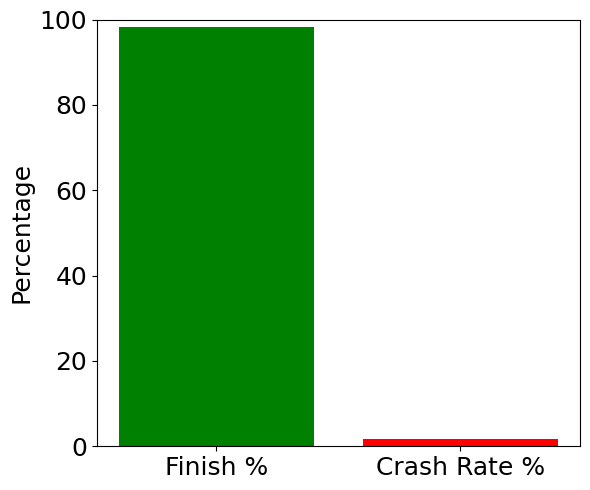

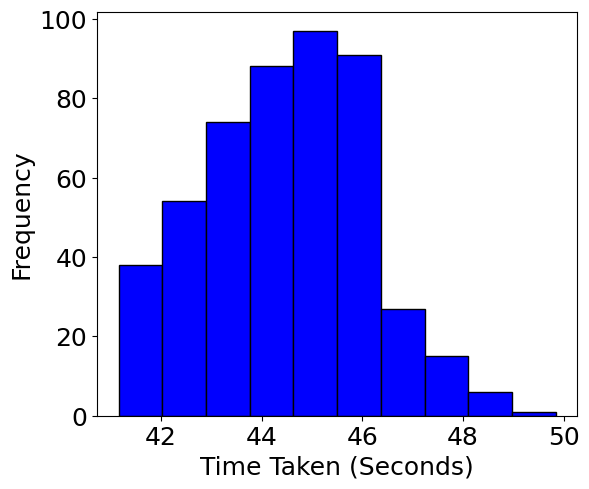

Average computation time (ms): 0.16
Maximum computation time (ms): 18.28


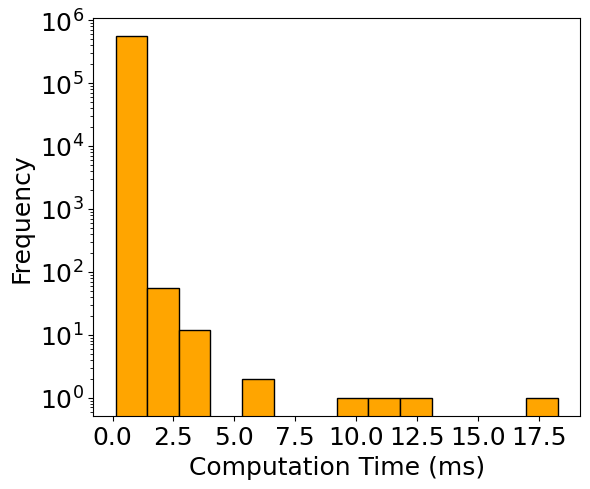

Average time taken (successful runs): 44.48
Fastest time taken: 41.16
Slowest time taken: 49.84


In [7]:
import matplotlib.pyplot as plt

# Centralized font size control
font_size = 18

# Compute statistics
finish_percent = (finishes / trials) * 100
crash_rate = (crashes / trials) * 100

# === Figure 1: Finish % and Crash Rate ===
plt.figure(figsize=(6, 5))
labels = ['Finish %', 'Crash Rate %']
values = [finish_percent, crash_rate]
plt.bar(labels, values, color=['green', 'red'])
plt.ylim(0, 100)
plt.ylabel('Percentage', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

# === Figure 2: Time Taken Histogram ===
plt.figure(figsize=(6, 5))
plt.hist(times, bins=10, color='blue', edgecolor='black')
plt.xlabel('Time Taken (Seconds)', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

avg_comp_time = sum(comp_times) / len(comp_times)
max_comp_time = max(comp_times)

print(f"Average computation time (ms): {avg_comp_time*1000:.2f}")
print(f"Maximum computation time (ms): {max_comp_time*1000:.2f}")

comp_times_ms = np.array(comp_times)*1000
# Manually define bin edges (example: creating bins with specific values)
bin_edges = np.linspace(min(comp_times_ms), max(comp_times_ms), 15)  # 15 bins from min to max time

# === Plot: Histogram of Computation Time (in ms) ===
plt.figure(figsize=(6, 5))

plt.hist(comp_times_ms, bins=bin_edges, color='orange', edgecolor='black')
plt.xlabel('Computation Time (ms)', fontsize=font_size)  # Change to ms
plt.ylabel('Frequency', fontsize=font_size)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Adjust font sizes
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tight_layout()
plt.show()


average_time = sum(times) / len(times)
fastest_time = min(times)
slowest_time = max(times)

print(f"Average time taken (successful runs): {average_time:.2f}")
print(f"Fastest time taken: {fastest_time:.2f}")
print(f"Slowest time taken: {slowest_time:.2f}")

In [10]:
print(comp_times_ms.shape)
count = np.sum(comp_times_ms > 10)
count

(550879,)


np.int64(3)